## Kaggle Python public API for data collection : Notebook Classification TASK

In [1]:
DATA_PATH_KEYWORDS = '../data/search_keywords.csv'
DATA_PATH_NOTEBOOKS = '../data/'

Importing librairies

In [2]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np

In [3]:
api = KaggleApi()
api.authenticate()

Read the file containing the search keywords used to retrieve notebooks 

In [5]:
keywords_df = pd.DataFrame(columns=['Category', 'Subcategory'])
keywords_df = pd.read_csv(DATA_PATH_KEYWORDS, sep=';') 
keywords_df

,subcategory,category
0,linear regression,regression
1,lasso regression,regression
2,randomforestregression,regression
3,ridge regression,regression
4,XGBRegressor,regression
...,...,...
89,sarsa,reinforcement learning
90,ddpg,reinforcement learning
91,qlearning,reinforcement learning
92,markov decision,reinforcement learning


The following function returns the category of a Notebook based on its subcategory

In [4]:
def search(sub,data):
    for i in data.index:
        if data.loc[i]['subcategory'] == sub:
            return data.loc[i]['category']

# List of notebooks

In [5]:
df = pd.DataFrame(columns=['title','subcategory','category'])

Building a notebook titles dataframe with category and subcategory

In [ ]:
for keyword in keywords_df['subcategory']:
    for i in range(1,11):
        try :
                kernels = api.kernels_list(search = keyword, page=i)
                for kernel in kernels:
                    df.loc[len(df)]=[kernel,keyword,search(keyword,keywords_df)]
        except Exception as e:
            print('Kaggle API exception :', kernel, 'Notebook not found')

In [13]:
df.head(10)

,title,subcategory,category
0,Linear Regression Tutorial,linear regression,regression
1,Car Price Prediction (Linear Regression - RFE),linear regression,regression
2,Multiple Linear Regression,linear regression,regression
3,Simple Linear Regression for Salary Data,linear regression,regression
4,Price analysis and Linear Regression,linear regression,regression
5,Linear Regression Project,linear regression,regression
6,PyTorch basics - Linear Regression from scratch,linear regression,regression
7,FIFA in depth analysis with Linear Regression,linear regression,regression
8,Sales Prediction (Simple Linear Regression),linear regression,regression
9,Linear Regression,linear regression,regression


Saving the dataframe to a .csv

In [ ]:
df.to_csv(DATA_PATH_NOTEBOOKS+'ntb_list.csv')

In [ ]:
means = (df.category.value_counts() / len(df)) * 100

meansdf = pd.DataFrame(columns=['category', 'means'])
meansdf.category = means.index
meansdf.means = means.values

meansdf

,category,means
0,nlp,31.588785
1,computer vision,22.565845
2,clustering,17.672048
3,regression,13.406967
4,classification,10.220901
5,reinforcement learning,4.392523


<AxesSubplot:xlabel='category', ylabel='means'>

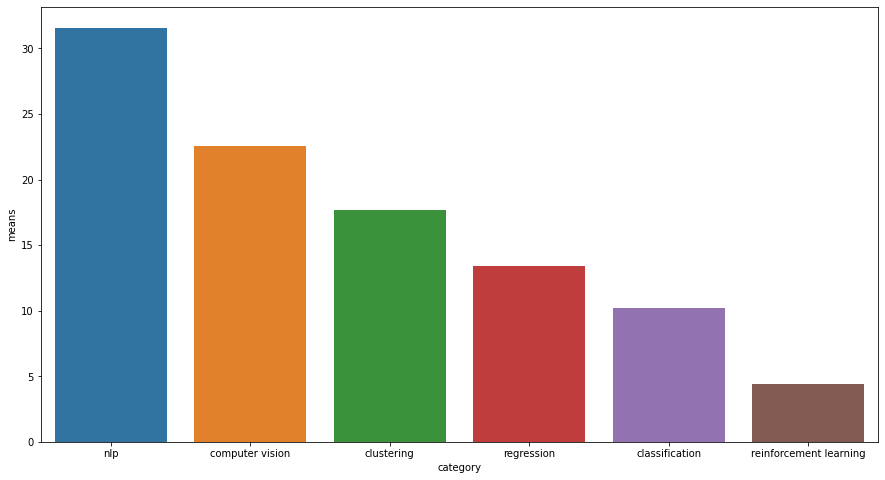

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))
sns.barplot(x='category', y='means', data=meansdf)


### Before collecting
- Delete duplicate notebooks : print duplicate categories => choose best category to keep
- Delete notebooks with non-english titles

In [21]:
df = pd.read_csv(DATA_PATH_NOTEBOOKS+'ntb_list.csv', sep=',', encoding='utf-8', index_col=0)
df.head()

,title,subcategory,category
0,Linear Regression Tutorial,linear regression,regression
1,Car Price Prediction (Linear Regression - RFE),linear regression,regression
2,Multiple Linear Regression,linear regression,regression
3,Simple Linear Regression for Salary Data,linear regression,regression
4,Price analysis and Linear Regression,linear regression,regression


In [22]:
df.shape

(11770, 3)

In [23]:
# a dict with duplicate titles and their respective positions in the df
duplicates = df[df.duplicated('title', keep=False)].groupby('title').groups

In [10]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [11]:
import collections

def to_be_dropped_indices(dictionary):
    to_be_dropped = [] # indices to be dropped from original df
    temp = []

    for k,v in dictionary.items():
        duplicates_df = df[df.index.isin(v.values)]
        
        # if the rows have the same category, they are all dropped except the last one
        if len(set(list(duplicates_df.category))) == 1:
            to_be_dropped.append(list(duplicates_df.index[:len(duplicates_df.category)-1]))

        else: 
            # drop least common category duplicates for a notebook
            dup_counter = collections.Counter(duplicates_df.category)
            most_common = dup_counter.most_common()[0][0]
            most_common_i = duplicates_df.index.where(duplicates_df.category == most_common).dropna()[0]

            to_be_dropped.append(duplicates_df.index.where(duplicates_df.index != most_common_i).dropna())

    return flatten_list(to_be_dropped)

Getting indices of rows to be dropped (duplicates)

In [24]:
to_be_dropped = to_be_dropped_indices(duplicates)
to_be_dropped[:10]

['8646',
 '7627',
 '9350',
 '6759',
 '9313',
 '10416',
 '2799',
 '2196',
 '9195',
 '9408']

Dropping duplicates

In [32]:
df_clean = df.copy()
df_clean.drop(to_be_dropped, inplace=True)
print(df_clean.shape)

(8816, 3)


#### Removing non-english titles

Let's write it to a new .csv file

In [ ]:
df.to_csv(DATA_PATH_NOTEBOOKS+'ntb_list_clean.csv')

In [84]:
import nltk
# nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dmasrour\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


In [155]:
for row in df_clean.index:
    try:
        print(df_clean.loc[row, 'title'])
        # title = "Chaii EDA&Baseline 実況"
        clean_title = " ".join(w for w in nltk.wordpunct_tokenize(df_clean.loc[row, 'title']) \
                if w.lower() in words or not w.isalpha())
        # if len(clean_title) < 3: print(title, '==', clean_title)
        # break
    except Exception as e:
        print(e, 'here', df_clean.title.where(df.index == row))


Car Price Prediction (Linear Regression - RFE)
Simple Linear Regression for Salary Data
Price analysis and Linear Regression
Linear Regression Project
PyTorch basics - Linear Regression from scratch
FIFA in depth analysis with Linear Regression
Sales Prediction (Simple Linear Regression)
Linear Regression
Predict Housing Prices - Simple Linear Regression
Simple Linear Regression Benchmark
Bike Sharing : Multiple Linear Regression
Cross-Validation with Linear Regression
Simple One Feature Linear Regression
Linear Regression from scratch (Gradient Descent)
Health Care Cost Prediction w/ Linear Regression
Linear Regression Portfolio Project
Linear Regression - Student-Marks
Housing Price Prediction ( Linear Regression )
Car Price Prediction ( Linear Regression )
Predictions with XGboost and Linear Regression
Simple Linear Regression in R 
Beginner Scikit-learn Linear Regression Tutorial 
A4 (demo). Linear regression as optimization 
Exercise: Linear Regression With Time Series
Linear Regr

ValueError: Array conditional must be same shape as self

# Collecting notebooks by category

In [52]:
for keyword in keywords_df['subcategory']:
    for i in range(1,16):
        try :
                kernels = api.kernels_list(search = keyword, page=i)
                for kernel in kernels:
                        api.kernels_pull(kernel.ref, path = DATA_PATH_NOTEBOOKS + search(keyword,keywords_df))
        except Exception as e:
            print('Kaggle API exception : ', kernel.ref, 'Notebook not found')

Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook no

In [21]:
import re
s = '<a class=""anchor"" id="2"></a>hkdfv'
result = re.search(r'<a class=""anchor""(.*?)</a>', s).group(1)
result = re.sub(r'<a class=""anchor"".*?</a>'," ",s)
result

' hkdfv'